In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import pandas as pd
import numpy as np
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet by Facebook
from fbprophet import Prophet

In [2]:
# importing train data to learn
train = pd.read_csv("../input/rossmann-store-sales/train.csv", 
                    parse_dates = True, low_memory = False, index_col = 'Date')

# additional store data
store = pd.read_csv("../input/rossmann-store-sales/store.csv", 
                    low_memory = False)
# time series as indexes
train.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(1)
memory usage: 69.8+ MB


In [4]:
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

In [5]:
# closed stores, the ones witch dont do sales
train[(train.Open == 0) & (train.Sales == 0)].head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


There're 172817 closed stores in the data well is about 10% of the total amount of observations. To avoid any biased forecasts we will drop these values.

What about opened stores with zero sales?

In [6]:
# opened stores with zero sales
zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
print("In total: ", zero_sales.shape)
zero_sales.head(5)


In total:  (54, 13)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,2015,5,15,20,NaN
2015-03-26,674,4,0,0,1,0,0,0,2015,3,26,13,NaN
2015-02-05,699,4,0,0,1,1,0,0,2015,2,5,6,NaN
2014-10-01,708,3,0,0,1,1,0,0,2014,10,1,40,NaN
2014-09-22,357,1,0,0,1,0,0,0,2014,9,22,39,NaN


Interestingly enough, there are opened store with no sales on working days. There're only 54 days in the data, so we can assume that there were external factors involved.


In [7]:
print("Closed stores and days which didn't have any sales won't be counted into the forecasts.")
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

print("In total: ", train.shape)

Closed stores and days which didn't have any sales won't be counted into the forecasts.
In total:  (844338, 13)


In [8]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,10.126675
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,9.342457
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,8.626118


In [9]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [10]:
# missing values?
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [11]:
# fill NaN with a median value (skewed distribuion)
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

In [12]:
# replace NA's by 0
store.fillna(0, inplace = True)

In [13]:
print("Joining train set with an additional store information.")

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

print("In total: ", train_store.shape)
train_store.head()

Joining train set with an additional store information.
In total:  (844338, 22)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [14]:
#now looking at how the stores have proformend
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


In [15]:
#let's print an overall sum of Sales and Customers to see which StoreType is the most selling and crowded one
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:3669: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



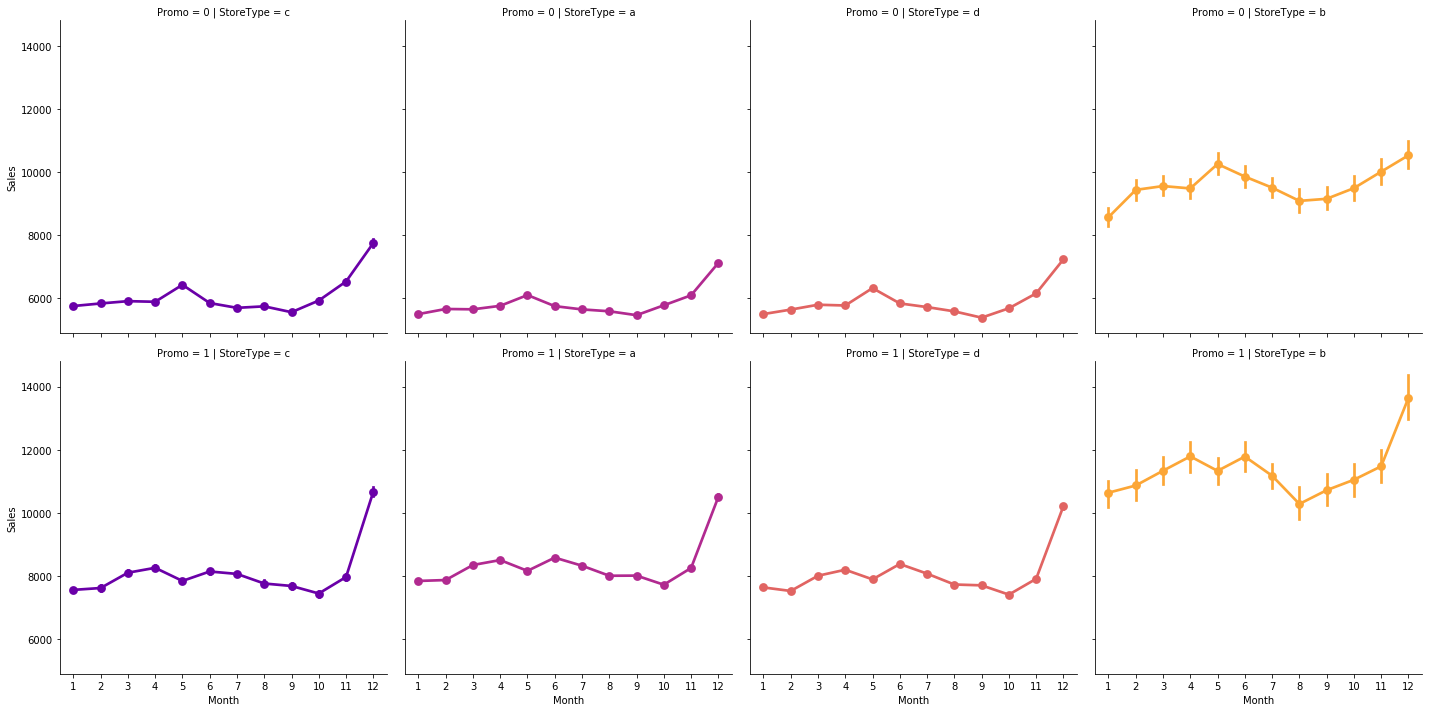

In [16]:
# sales trends
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
              )

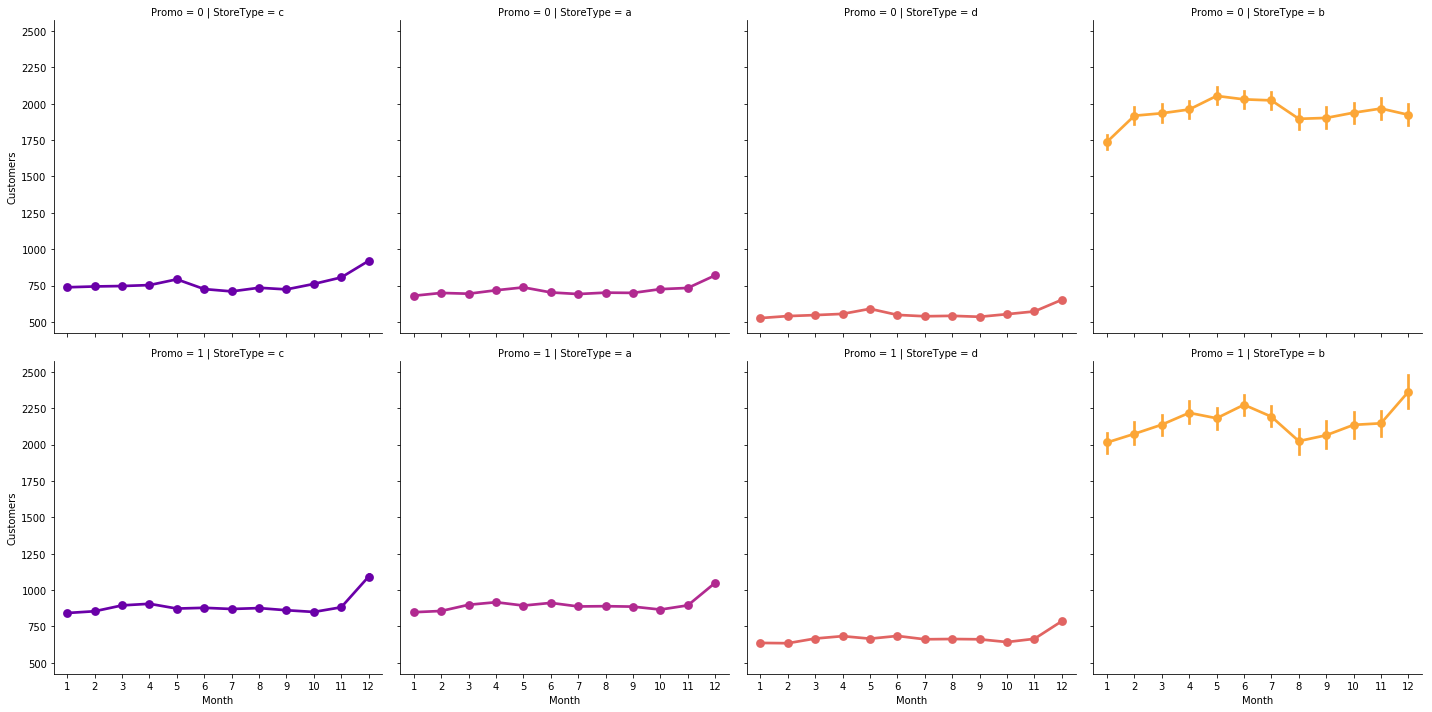

In [17]:
# sales trends
sns.factorplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               #color = c
              )

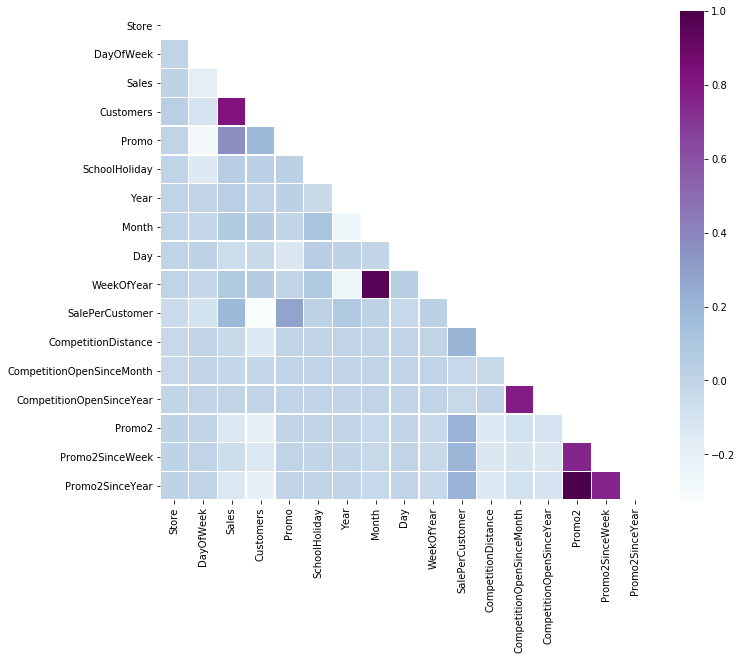

In [18]:
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = train_store.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

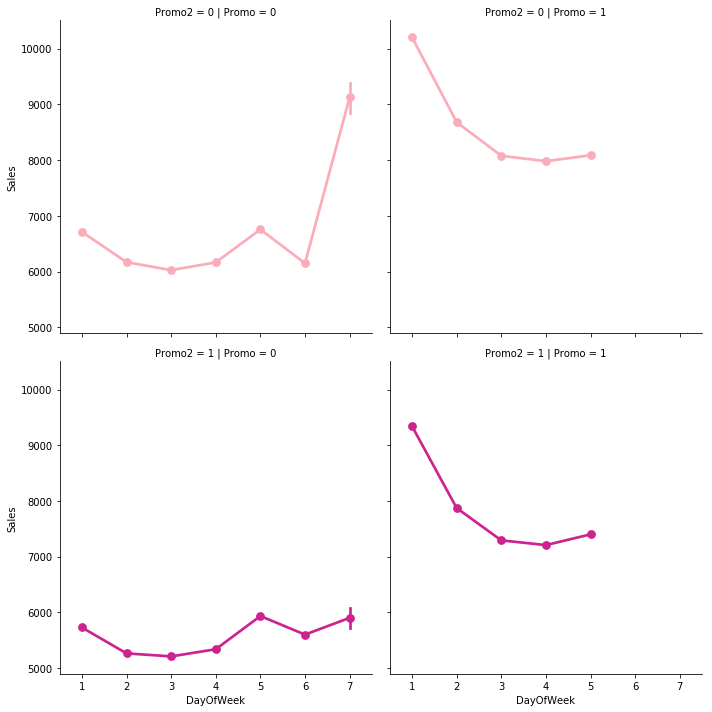

In [19]:
# sale per customer trends
sns.factorplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               palette = 'RdPu')

### Time Series Analysis and Forecasting with Prophet

In [20]:
# importing data
df = pd.read_csv("../input/rossmann-store-sales/train.csv")

# remove closed stores and those with no sales
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]

# sales for the store number 1 (StoreType C)
sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.



Date     datetime64[ns]
Sales             int64
dtype: object

In [21]:
# from the prophet documentation every variables should have specific names
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

,ds,y
1014980,2013-01-02,5530
1013865,2013-01-03,4327
1012750,2013-01-04,4486
1011635,2013-01-05,4997
1009405,2013-01-07,7176


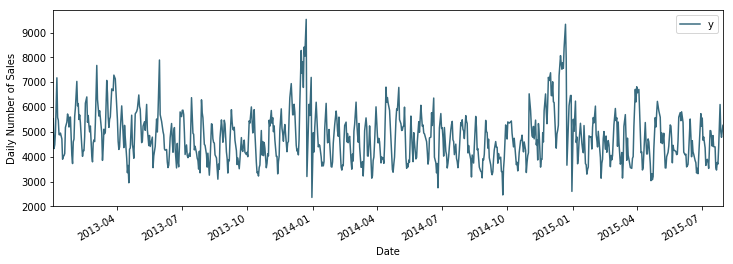

In [23]:
# plot daily sales
c = '#386B7F'
ax = sales.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

### Modeling Holidays

In [24]:
# create holidays dataframe
state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [25]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.95, 
                   holidays = holidays)
my_model.fit(sales)

# dataframe that extends into future 6 weeks 
future_dates = my_model.make_future_dataframe(periods = 6*7)

print("First week to forecast.")
future_dates.tail(7)

First week to forecast.


,ds
816,2015-09-05
817,2015-09-06
818,2015-09-07
819,2015-09-08
820,2015-09-09
821,2015-09-10
822,2015-09-11


In [26]:

# predictions
forecast = my_model.predict(future_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
816,2015-09-05,4092.135712,2484.356294,5703.687371
817,2015-09-06,4087.032784,2515.243592,5708.178161
818,2015-09-07,4161.813517,2652.673873,5867.852399
819,2015-09-08,3664.142168,2141.186661,5286.518958
820,2015-09-09,3550.915165,1876.199442,5184.540481
821,2015-09-10,3462.435748,1965.121656,5177.006769
822,2015-09-11,3717.122489,2138.355833,5272.925025


In [27]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

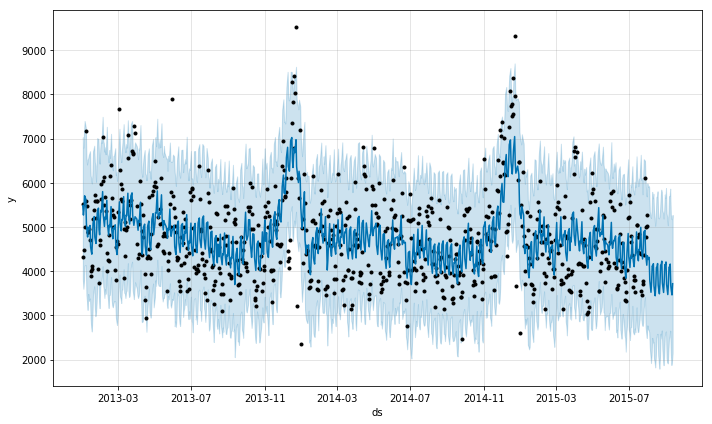

In [28]:
# visualizing predicions
my_model.plot(forecast);

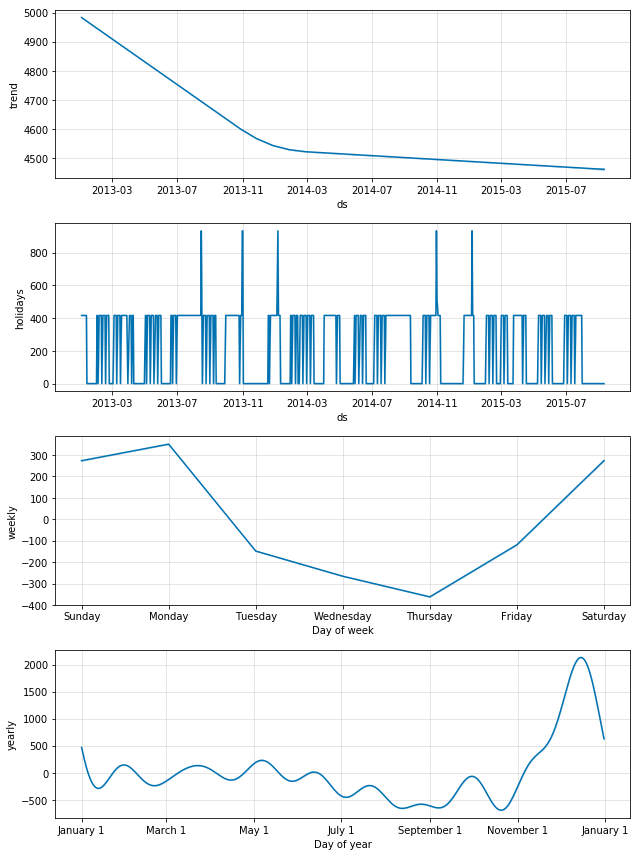

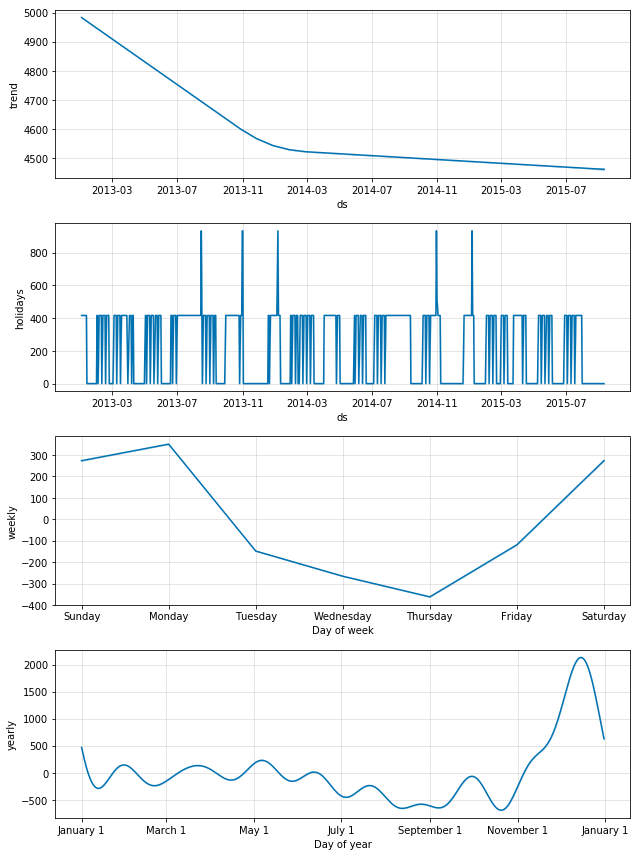

In [29]:
my_model.plot_components(forecast)

he first plot shows that the monthly sales of store number 1 has been linearly decreasing over time and the second shows the holiays gaps included in the model. The third plot highlights the fact that the weekly volume of last week sales peaks towards the Monday of the next week, while the forth plot shows that the most buzy season occurs during the Christmas holidays.

In [30]:

# to predict to
test = pd.read_csv("../input/rossmann-store-sales/test.csv", 
                    parse_dates = True, low_memory = False, index_col = 'Date')
test.head()

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2015-09-17,1,1,4,1.0,1,0,0
2015-09-17,2,3,4,1.0,1,0,0
2015-09-17,3,7,4,1.0,1,0,0
2015-09-17,4,8,4,1.0,1,0,0
2015-09-17,5,9,4,1.0,1,0,0


In [31]:
# test: missing values?
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [32]:
test[pd.isnull(test.Open)]

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2015-09-17,480,622,4,NaN,1,0,0
2015-09-16,1336,622,3,NaN,1,0,0
2015-09-15,2192,622,2,NaN,1,0,0
2015-09-14,3048,622,1,NaN,1,0,0
2015-09-12,4760,622,6,NaN,0,0,0
2015-09-11,5616,622,5,NaN,0,0,0
2015-09-10,6472,622,4,NaN,0,0,0
2015-09-09,7328,622,3,NaN,0,0,0
2015-09-08,8184,622,2,NaN,0,0,0


In [33]:

# replace NA's in Open variable by 1 
test.fillna(1, inplace = True)

Data Encoding
XGBoost doesn't support anything else than numbers. So prior to modeling we need to encode certain factor variables into numerical plus extract dates as we did before for the train set

In [34]:
# data extraction
test['Year'] = test.index.year
test['Month'] = test.index.month
test['Day'] = test.index.day
test['WeekOfYear'] = test.index.weekofyear

# to numerical
mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
test.StateHoliday.replace(mappings, inplace = True)

train_store.Assortment.replace(mappings, inplace = True)
train_store.StoreType.replace(mappings, inplace = True)
train_store.StateHoliday.replace(mappings, inplace = True)
train_store.drop('PromoInterval', axis = 1, inplace = True)

store.StoreType.replace(mappings, inplace = True)
store.Assortment.replace(mappings, inplace = True)
store.drop('PromoInterval', axis = 1, inplace = True)

In [35]:
# take a look on the train and store again
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,WeekOfYear,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
0,1,5,5263,555,1,1,0,1,2015,7,...,31,9.482883,3,1,1270.0,9.0,2008.0,0,0.0,0.0
1,1,4,5020,546,1,1,0,1,2015,7,...,31,9.194139,3,1,1270.0,9.0,2008.0,0,0.0,0.0
2,1,3,4782,523,1,1,0,1,2015,7,...,31,9.143403,3,1,1270.0,9.0,2008.0,0,0.0,0.0
3,1,2,5011,560,1,1,0,1,2015,7,...,31,8.948214,3,1,1270.0,9.0,2008.0,0,0.0,0.0
4,1,1,6102,612,1,1,0,1,2015,7,...,31,9.970588,3,1,1270.0,9.0,2008.0,0,0.0,0.0


In [36]:
print("Joining test set with an additional store information.")
test_store = pd.merge(test, store, how = 'inner', on = 'Store')

test_store['CompetitionOpen'] = 12 * (test_store.Year - test_store.CompetitionOpenSinceYear) + (test_store.Month - test_store.CompetitionOpenSinceMonth)
test_store['PromoOpen'] = 12 * (test_store.Year - test_store.Promo2SinceYear) + (test_store.WeekOfYear - test_store.Promo2SinceWeek) / 4.0

print("In total: ", test_store.shape)
test_store.head()

Joining test set with an additional store information.
In total:  (41088, 21)


,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpen,PromoOpen
0,1,1,4,1.0,1,0,0,2015,9,17,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
1,857,1,3,1.0,1,0,0,2015,9,16,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
2,1713,1,2,1.0,1,0,0,2015,9,15,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
3,2569,1,1,1.0,1,0,0,2015,9,14,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
4,3425,1,7,0.0,0,0,0,2015,9,13,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.25


In [37]:
# split into training and evaluation sets
# excluding Sales and Id columns
predictors = [x for x in train_store.columns if x not in ['Customers', 'Sales', 'SalePerCustomer']]
y = np.log(train_store.Sales) # log transformation of Sales
X = train_store
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor # wrapper
# split the data into train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, # 30% for the evaluation set
                                                    random_state = 42)

In [38]:
# predictors
X.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'SalePerCustomer', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear'],
      dtype='object')

In [39]:
# evaluation metric: rmspe
# Root Mean Square Percentage Error
# code chunk shared at Kaggle

def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat / y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y, yhat)

In [40]:
# base parameters
params = {
    'booster': 'gbtree', 
    'objective': 'reg:linear', # regression task
    'subsample': 0.8, # 80% of data to grow trees and prevent overfitting
    'colsample_bytree': 0.85, # 85% of features used
    'eta': 0.1, 
    'max_depth': 10, 
    'seed': 42} # for reproducible results

In [50]:
X_train[predictors]

,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
633180,838,3,1,0,0,1,2013,10,30,44,4,3,6890.0,0.0,0.0,1,48.0,2011.0
230273,307,1,1,0,0,0,2013,12,9,50,1,1,18660.0,9.0,2002.0,0,0.0,0.0
480860,636,3,1,1,0,0,2013,5,15,20,3,1,720.0,10.0,2004.0,1,13.0,2010.0
163546,219,1,1,0,0,0,2015,2,23,9,1,1,1640.0,2.0,2013.0,0,0.0,0.0
151275,202,6,1,0,0,0,2013,1,19,3,4,3,5140.0,5.0,2010.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,344,2,1,0,0,0,2013,8,6,32,1,3,300.0,4.0,2011.0,1,14.0,2011.0
365838,484,3,1,1,0,1,2014,4,16,16,1,3,14300.0,3.0,2011.0,0,0.0,0.0
131932,176,3,1,1,0,0,2013,2,6,6,1,1,3770.0,0.0,0.0,0,0.0,0.0
671155,889,2,1,0,0,1,2014,8,26,35,4,1,18670.0,12.0,2005.0,0,0.0,0.0


In [55]:
# XGB with xgboost library
X_train['StateHoliday'] = pd.to_numeric(X_train['StateHoliday'])
X_train['Assortment'] = pd.to_numeric(X_train['Assortment'])
X_test['StateHoliday'] = pd.to_numeric(X_test['StateHoliday'])
X_test['Assortment'] = pd.to_numeric(X_test['Assortment'])
dtrain = xgb.DMatrix(X_train[predictors], y_train)
dtest = xgb.DMatrix(X_test[predictors], y_test)


watchlist = [(dtrain, 'train'), (dtest, 'test')]

xgb_model = xgb.train(params, dtrain, 300, evals = watchlist,
                      early_stopping_rounds = 50, feval = rmspe_xg, verbose_eval = True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stabl

[09:55:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:7.44344	test-rmse:7.44314	train-rmspe:0.999527	test-rmspe:0.999527
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 50 rounds.
[1]	train-rmse:6.70102	test-rmse:6.70073	train-rmspe:0.998821	test-rmspe:0.998822
[2]	train-rmse:6.03285	test-rmse:6.03253	train-rmspe:0.997547	test-rmspe:0.997548
[3]	train-rmse:5.43154	test-rmse:5.43118	train-rmspe:0.995404	test-rmspe:0.995406
[4]	train-rmse:4.89049	test-rmse:4.89014	train-rmspe:0.992011	test-rmspe:0.992014
[5]	train-rmse:4.4037	test-rmse:4.40334	train-rmspe:0.986939	test-rmspe:0.986942
[6]	train-rmse:3.96572	test-rmse:3.96538	train-rmspe:0.979737	test-rmspe:0.979741
[7]	train-rmse:3.57181	test-rmse:3.57145	train-rmspe:0.969939	test-rmspe:0.96994
[8]	train-rmse:3.21749	test-rmse:3.21714	train-rmspe:0.957164	test-rmspe:0

[95]	train-rmse:0.147695	test-rmse:0.150463	train-rmspe:0.211668	test-rmspe:0.164598
[96]	train-rmse:0.146975	test-rmse:0.149739	train-rmspe:0.211068	test-rmspe:0.163779
[97]	train-rmse:0.145383	test-rmse:0.148176	train-rmspe:0.209269	test-rmspe:0.162033
[98]	train-rmse:0.145014	test-rmse:0.14782	train-rmspe:0.208918	test-rmspe:0.161682
[99]	train-rmse:0.144638	test-rmse:0.147462	train-rmspe:0.20863	test-rmspe:0.161331
[100]	train-rmse:0.144071	test-rmse:0.146903	train-rmspe:0.200339	test-rmspe:0.160716
[101]	train-rmse:0.143625	test-rmse:0.14652	train-rmspe:0.197939	test-rmspe:0.160328
[102]	train-rmse:0.142737	test-rmse:0.145633	train-rmspe:0.197212	test-rmspe:0.159412
[103]	train-rmse:0.140779	test-rmse:0.143707	train-rmspe:0.195773	test-rmspe:0.157324
[104]	train-rmse:0.140455	test-rmse:0.143395	train-rmspe:0.195438	test-rmspe:0.157009
[105]	train-rmse:0.140008	test-rmse:0.142976	train-rmspe:0.194845	test-rmspe:0.156573
[106]	train-rmse:0.139091	test-rmse:0.142115	train-rmspe:0.194

[191]	train-rmse:0.106308	test-rmse:0.111909	train-rmspe:0.139018	test-rmspe:0.123502
[192]	train-rmse:0.105804	test-rmse:0.111444	train-rmspe:0.138536	test-rmspe:0.123007
[193]	train-rmse:0.105551	test-rmse:0.111237	train-rmspe:0.138247	test-rmspe:0.122802
[194]	train-rmse:0.105387	test-rmse:0.111106	train-rmspe:0.138062	test-rmspe:0.122675
[195]	train-rmse:0.10529	test-rmse:0.111025	train-rmspe:0.137985	test-rmspe:0.122595
[196]	train-rmse:0.105139	test-rmse:0.110909	train-rmspe:0.137842	test-rmspe:0.122455
[197]	train-rmse:0.105067	test-rmse:0.110847	train-rmspe:0.137451	test-rmspe:0.122386
[198]	train-rmse:0.104943	test-rmse:0.110751	train-rmspe:0.137408	test-rmspe:0.122294
[199]	train-rmse:0.104655	test-rmse:0.1105	train-rmspe:0.13714	test-rmspe:0.122047
[200]	train-rmse:0.104517	test-rmse:0.110394	train-rmspe:0.137012	test-rmspe:0.121907
[201]	train-rmse:0.104419	test-rmse:0.11033	train-rmspe:0.136923	test-rmspe:0.121848
[202]	train-rmse:0.104092	test-rmse:0.110043	train-rmspe:0.

[287]	train-rmse:0.092102	test-rmse:0.100918	train-rmspe:0.118381	test-rmspe:0.111871
[288]	train-rmse:0.092019	test-rmse:0.100884	train-rmspe:0.117579	test-rmspe:0.111836
[289]	train-rmse:0.091987	test-rmse:0.100866	train-rmspe:0.117294	test-rmspe:0.111811
[290]	train-rmse:0.091914	test-rmse:0.100812	train-rmspe:0.117222	test-rmspe:0.111748
[291]	train-rmse:0.091799	test-rmse:0.100748	train-rmspe:0.11698	test-rmspe:0.111658
[292]	train-rmse:0.091671	test-rmse:0.100662	train-rmspe:0.116817	test-rmspe:0.111548
[293]	train-rmse:0.091617	test-rmse:0.10064	train-rmspe:0.116756	test-rmspe:0.11153
[294]	train-rmse:0.09153	test-rmse:0.100594	train-rmspe:0.116698	test-rmspe:0.111483
[295]	train-rmse:0.091444	test-rmse:0.100542	train-rmspe:0.116619	test-rmspe:0.111436
[296]	train-rmse:0.091392	test-rmse:0.100513	train-rmspe:0.116532	test-rmspe:0.111403
[297]	train-rmse:0.091312	test-rmse:0.10045	train-rmspe:0.116458	test-rmspe:0.111344
[298]	train-rmse:0.091218	test-rmse:0.100375	train-rmspe:0.

In [56]:
# predictors
X.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'SalePerCustomer', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear'],
      dtype='object')

In [57]:
# the same parameters as for xgboost model
params_sk = {'max_depth': 10, 
            'n_estimators': 300, # the same as num_rounds in xgboost
            'objective': 'reg:linear', 
            'subsample': 0.8, 
            'colsample_bytree': 0.85, 
            'learning_rate': 0.1, 
            'seed': 42}     

skrg = XGBRegressor(**params_sk)

skrg.fit(X_train, y_train)

[10:02:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.85, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=300,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=None, subsample=0.8, verbosity=1)

In [ ]:
import scipy.stats as st

params_grid = {  
    'learning_rate': st.uniform(0.01, 0.3),
    'max_depth': list(range(10, 20, 2)),
    'gamma': st.uniform(0, 10),
    'reg_alpha': st.expon(0, 50)}

search_sk = RandomizedSearchCV(skrg, params_grid, cv = 5) # 5 fold cross validation
search_sk.fit(X_train, y_train)

# best parameters
print(search_sk.best_params_); print(search_sk.best_score_)

[10:12:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[10:18:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[10:25:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:

# with new parameters
params_new = {
    'booster': 'gbtree', 
    'objective': 'reg:linear', 
    'subsample': 0.8, 
    'colsample_bytree': 0.85, 
    'eta': 0.044338624448041611, 
    'max_depth': 16, 
    'gamma': 0.80198330585415034,
    'reg_alpha': 23.008226565535971,
    'seed': 42} 

model_final = xgb.train(params_new, dtrain, 300, evals = watchlist,
                        early_stopping_rounds = 50, feval = rmspe_xg, verbose_eval = True)

In [ ]:

yhat = model_final.predict(xgb.DMatrix(X_test[predictors]))
error = rmspe(X_test.Sales.values, np.exp(yhat))

print('First validation yelds RMSPE: {:.6f}'.format(error))

In [ ]:
xgb.plot_importance(model_final)